<a href="https://colab.research.google.com/github/Morganite-Hub/Homemade-applet/blob/main/Year_World_cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Authenticate and access Google Cloud services
from google.colab import auth
auth.authenticate_user()

# Let's import data first
# Run the code and upload the csv file from your laptop
from google.colab import files
# uploaded = files.upload()

### Query data from restaurant data file

In [ ]:
# Import the necessary libraries
from google.cloud import storage
from google.cloud import bigquery

# First make connection to BigQuery
# Replace 'your-project-id' with your Google Cloud project ID
# Replace 'your-dataset-name' with your dataset name
project_id = "whyso-project-0621"
dataset_name = "restaurant_dataset"
table_name = "restaurant_tips" # if you make changes previously, then here you need to make according change

bigquery_client = bigquery.Client(project=project_id)

In [ ]:
# Query all data from the table
query = f"""
    SELECT *
    FROM `{project_id}.{dataset_name}.{table_name}`
    WHERE EXTRACT(YEAR from date) = 2009
"""

query_job = bigquery_client.query(query)
results = query_job.result()

tips_df = query_job.to_dataframe()
tips_df.head()

,user_id,business_id,text,date,compliment_count
0,A5kkLvxwVS5jJZdS0Gm4ww,M1hsyjJDdQQeNP164FJ1pA,"Creole Creamery is just down the street, great...",2009-05-01 04:52:28+00:00,0
1,F5he-BIIB1vRr_BpdZzJTw,UNtta3w643ZWsJ7JDxhC9g,Get the steak sandwich with spagetti as your s...,2009-12-08 21:13:45+00:00,0
2,F5he-BIIB1vRr_BpdZzJTw,UNtta3w643ZWsJ7JDxhC9g,Get one of their layers beers.,2009-12-08 20:36:45+00:00,0
3,4XA9DIbUIbcnkBZFLgs_2Q,sXaiyPC1fT6ESl-6t7eSXg,Deep fried cheddar cheese balls!,2009-06-22 15:26:59+00:00,0
4,tzDfx3wfWTqtV0kxMJxKLg,vxLV9tci88Hsr1G01uleag,Amazing white pizza!!!,2009-07-24 22:18:50+00:00,0


In [ ]:
!pip install contractions
import re
import string
import contractions
import nltk
import gensim
from gensim.utils import simple_preprocess
import spacy
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

target_column = 'text'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# drop data with missing values in the 'content' column
tips_df = tips_df.dropna(subset=[target_column])

# drop duplicate review content
tips_df = tips_df.drop_duplicates(subset=[target_column])

# remove contraction
tips_df[target_column] = tips_df[target_column].map(lambda x: contractions.fix(x))

# convert the relevant column to lowercase
tips_df[target_column] = tips_df[target_column].str.lower()

# Remove overspace
tips_df[target_column] = tips_df[target_column].map(lambda x: re.sub('\s{2,}', " ", x))

# Remove non-word characters, so numbers and ___ etc
tips_df[target_column] = tips_df[target_column].str.replace("[^A-Za-z]", " ", regex = True)

# Remove punctuation
tips_df[target_column] = tips_df[target_column].map(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

In [ ]:
# create a list of the contents from the 'contents' column
words = tips_df[target_column].tolist()

# tokenise the words
word_tokens = []
for content in words:
    word_tokens.append(word_tokenize(content))

# create bigram model
bigram = gensim.models.phrases.Phrases(word_tokens, min_count=3, threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram) # Faster way to get a sentence clubbed as a trigram/bigram

# NLTK Stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['food','great','good','go']) #add more stopwords here

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Define functions for stopwords, bigrams and lemmatisation
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove stopwords
data_words_nostops = remove_stopwords(word_tokens)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatisation keeping only noun, adj, vb, adv
data_lemmatised = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# put the tokens back together as text to have our filtered contents

rejoin = []
for content in data_lemmatised: # Here we choose to use stemming instead of lemmatisation
    x = " ".join(content) # join the text back together
    rejoin.append(x)

# add the reformed text to the data frame
tips_df['cleaned_review'] = rejoin

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tips_df.head()

,user_id,business_id,text,date,compliment_count,cleaned_review
0,A5kkLvxwVS5jJZdS0Gm4ww,M1hsyjJDdQQeNP164FJ1pA,creole creamery is just down the street great...,2009-05-01 04:52:28+00:00,0,place dairy dessert
1,F5he-BIIB1vRr_BpdZzJTw,UNtta3w643ZWsJ7JDxhC9g,get the steak sandwich with spagetti as your s...,2009-12-08 21:13:45+00:00,0,get steak sandwich side
2,F5he-BIIB1vRr_BpdZzJTw,UNtta3w643ZWsJ7JDxhC9g,get one of their layers beers,2009-12-08 20:36:45+00:00,0,get layer beer
3,4XA9DIbUIbcnkBZFLgs_2Q,sXaiyPC1fT6ESl-6t7eSXg,deep fried cheddar cheese balls,2009-06-22 15:26:59+00:00,0,deep fried cheddar cheese ball
4,tzDfx3wfWTqtV0kxMJxKLg,vxLV9tci88Hsr1G01uleag,amazing white pizza,2009-07-24 22:18:50+00:00,0,amazing white pizza


### Build the LDA model

<ipython-input-104-6f744ac64ccf>:10: RuntimeWarning: `words` should be an iterable of str.
  mdl.add_doc(words)
<ipython-input-104-6f744ac64ccf>:11: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  mdl.train(20)


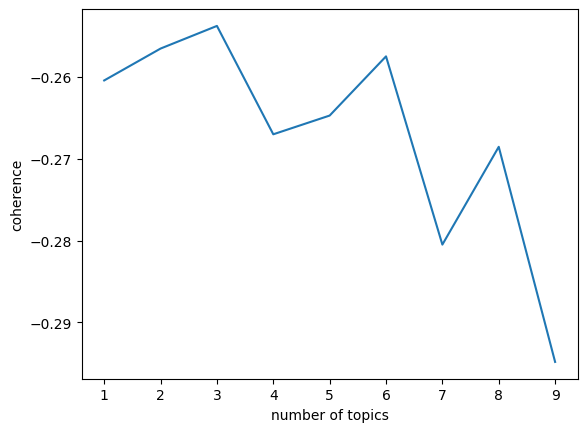

In [ ]:
!pip install tomotopy
import tomotopy as tp
import matplotlib.pyplot as plt
def find_k(docs,min_k=1,max_k=20,min_df=2):
  scores = []
  for k in range(min_k,max_k):
    mdl = tp.LDAModel(min_df=min_df,k=k,seed = 555)
    for words in docs:
      if words:
        mdl.add_doc(words)
    mdl.train(20)
    coh = tp.coherence.Coherence(mdl)
    scores.append(coh.get_score())
  plt.plot(range(min_k,max_k),scores)
  plt.xlabel('number of topics')
  plt.ylabel('coherence')
  plt.show()

find_k(docs=tips_df['cleaned_review'],min_k=1,max_k=10,min_df=2)

In [ ]:
# vectorise the data into word counts

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

max_words = 1000 #how many words taking account for topic modeling
vectorizer = CountVectorizer(max_features=max_words)
vec = vectorizer.fit_transform(tips_df['cleaned_review'])

k = 4 #this is the number of the topic. you can decide the number

lda = LDA(n_components=k, max_iter=5, learning_method='online', random_state = 10)
lda.fit(vec)

LatentDirichletAllocation(learning_method='online', max_iter=5, n_components=4,
                          random_state=10)

### Visualisation of the topics

Topic#  1
close,get,well,special,go,eat,early,brunch,lunch,sunday,fish,try,stuff,price,cheese,amazing,way,order,business,style,soup,bring,walk,bathroom,due,worth,sandwich,long,pie,door,smell,bottle,ingredient,top,add,selection,much,offer,com,steak,indy,spicy,late,trader,shopping,point,accesible,easily,stromboli,sushi,truck,brownsburg,beef,hope,economy,dinner,innovative,bot,poor,expect,wrong,whiskey,currently,think,rush,especially,regret,line,money,extensive,sure,quick,dine,chicken,friend,website,french,cut,place,wine,half,correct,winner,new,hear,hot,cool,appetizer,brisket,vacation,sake,chocolate,though,sauce,mary,bloody,guacamole,address,beat,serve

Topic#  2
pizza,chicken,excellent,come,also,away,area,order,sit,parking,enjoy,seat,stay,crowd,atmosphere,kid,check,restaurant,wing,see,back,best_pizza,recommend,lake,free,indy,quickly,next,sub,lot,dinner,always,big,right,turn,family,actually,run,summer,smoke,leave,week,room,bacon,place,get,favorite,downtown,egg,do,play,menu,want,lunch,tende

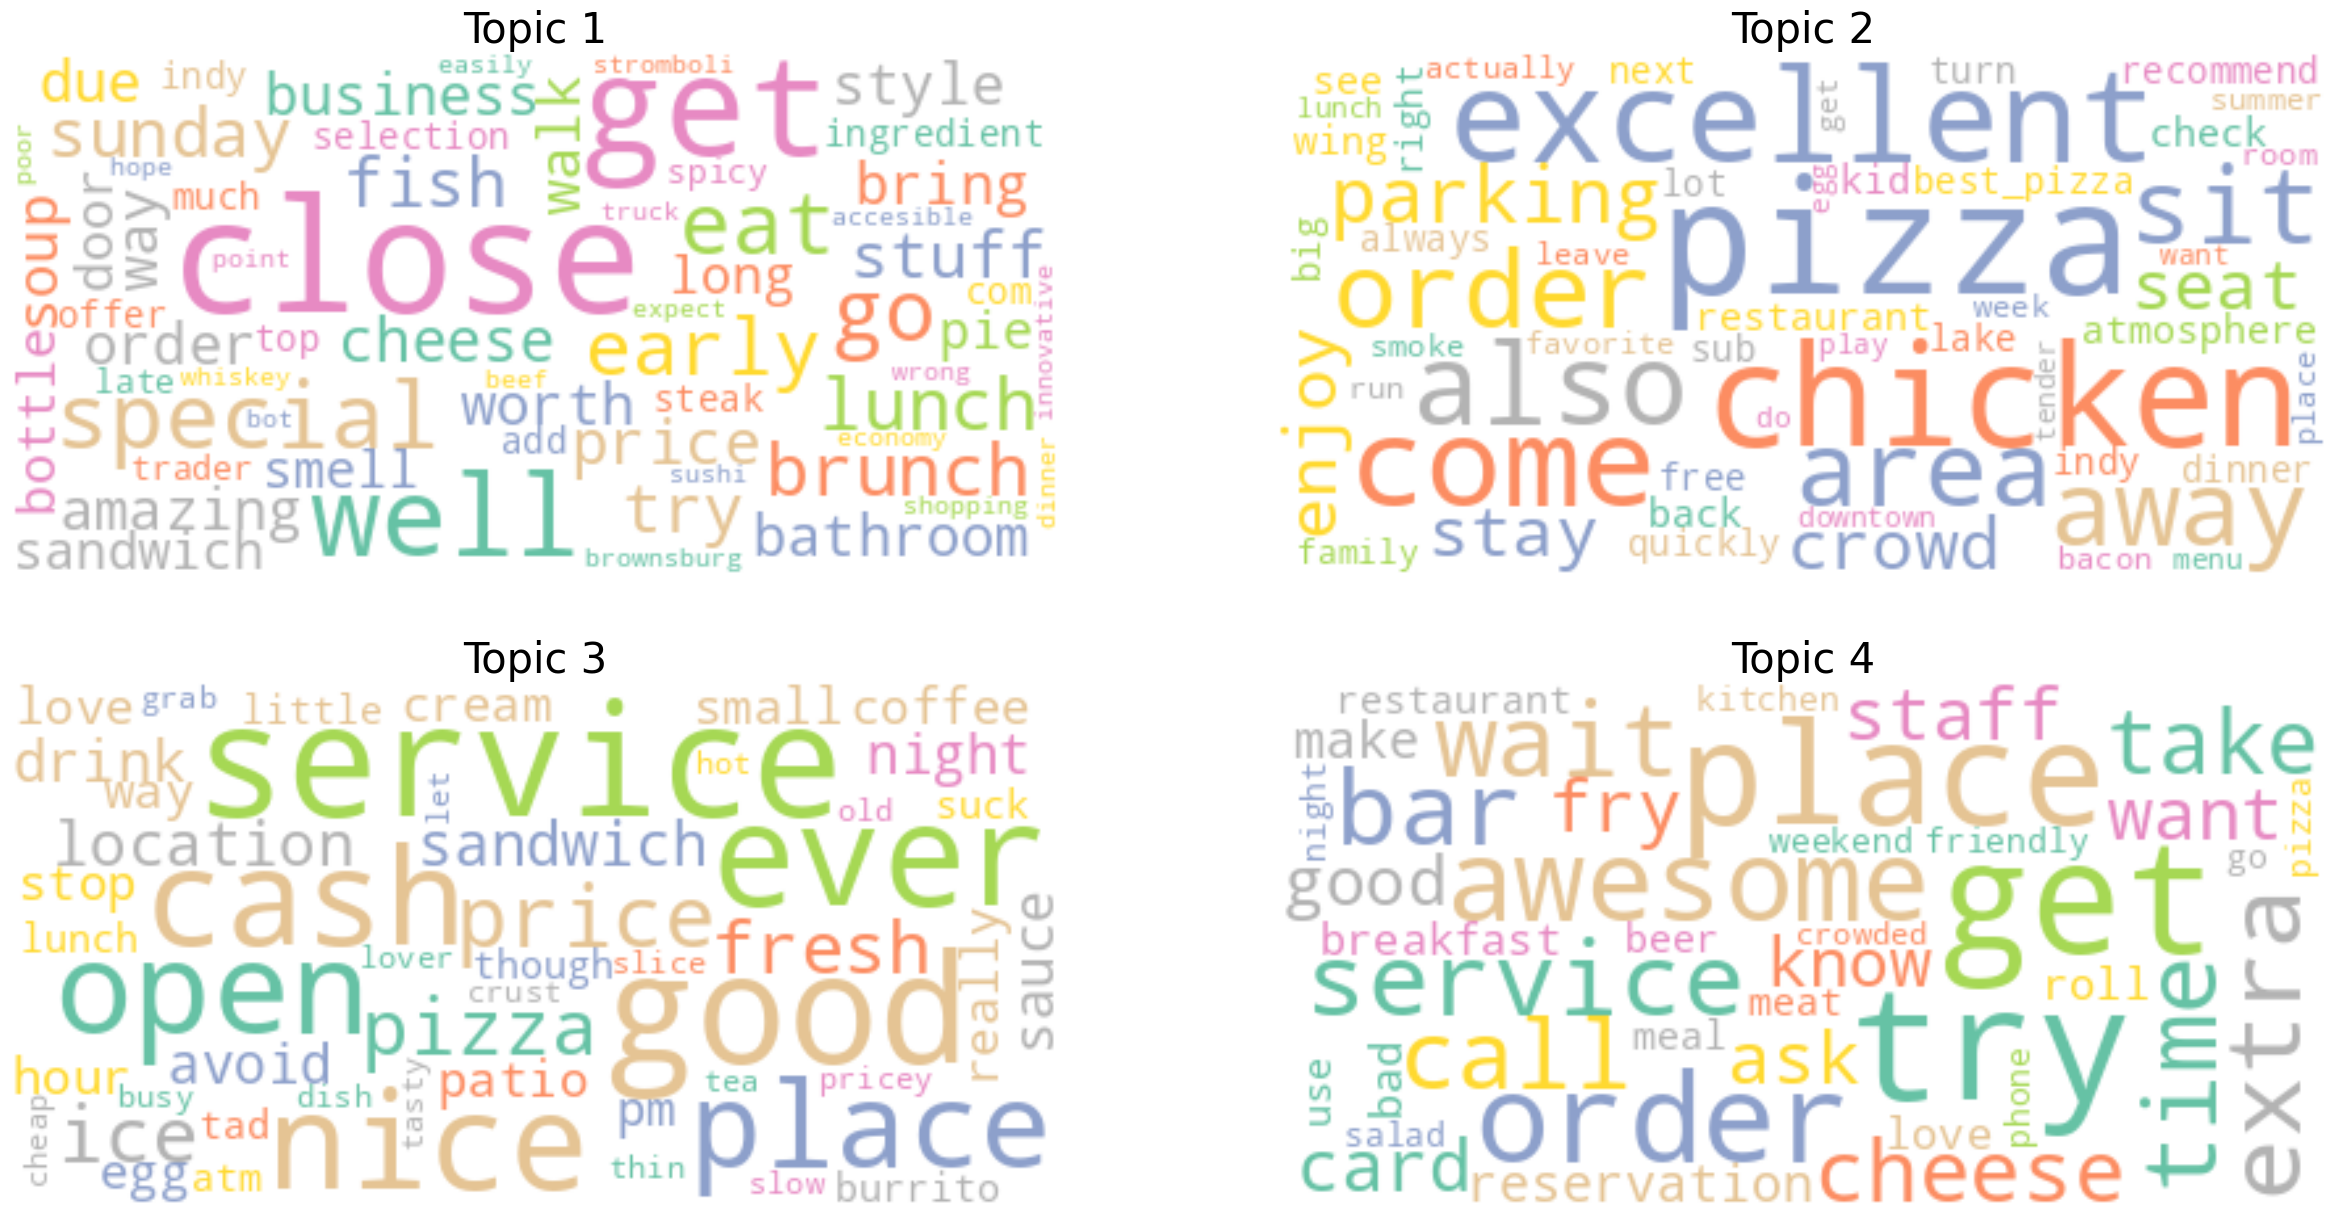

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import wordcloud

#declaring number of terms we need per topic
terms_count = 100

terms = vectorizer.get_feature_names_out()

wcloud = wordcloud.WordCloud(background_color="White",mask=None, max_words=100,\
                             max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
                             contour_width=3,contour_color='Black',colormap='Set2')

fig, axes = plt.subplots(2,2, figsize=(30, 15), sharex=True)
axes = axes.flatten()

for idx,topic in enumerate(lda.components_):
    print('Topic# ',idx+1)
    abs_topic = abs(topic)
    topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
    for i in range(terms_count):
        topic_words.append(topic_terms_sorted[i][0])
    print(','.join( word for word in topic_words))
    print("")
    dict_word_frequency = {}

    for i in range(terms_count):
        dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]

    ax = axes[idx]
    ax.set_title(f'Topic {idx +1}',fontdict={'fontsize': 30})
    wcloud.generate_from_frequencies(dict_word_frequency)
    ax.imshow(wcloud, interpolation='bilinear')
    ax.axis("off")
print(lda.components_)

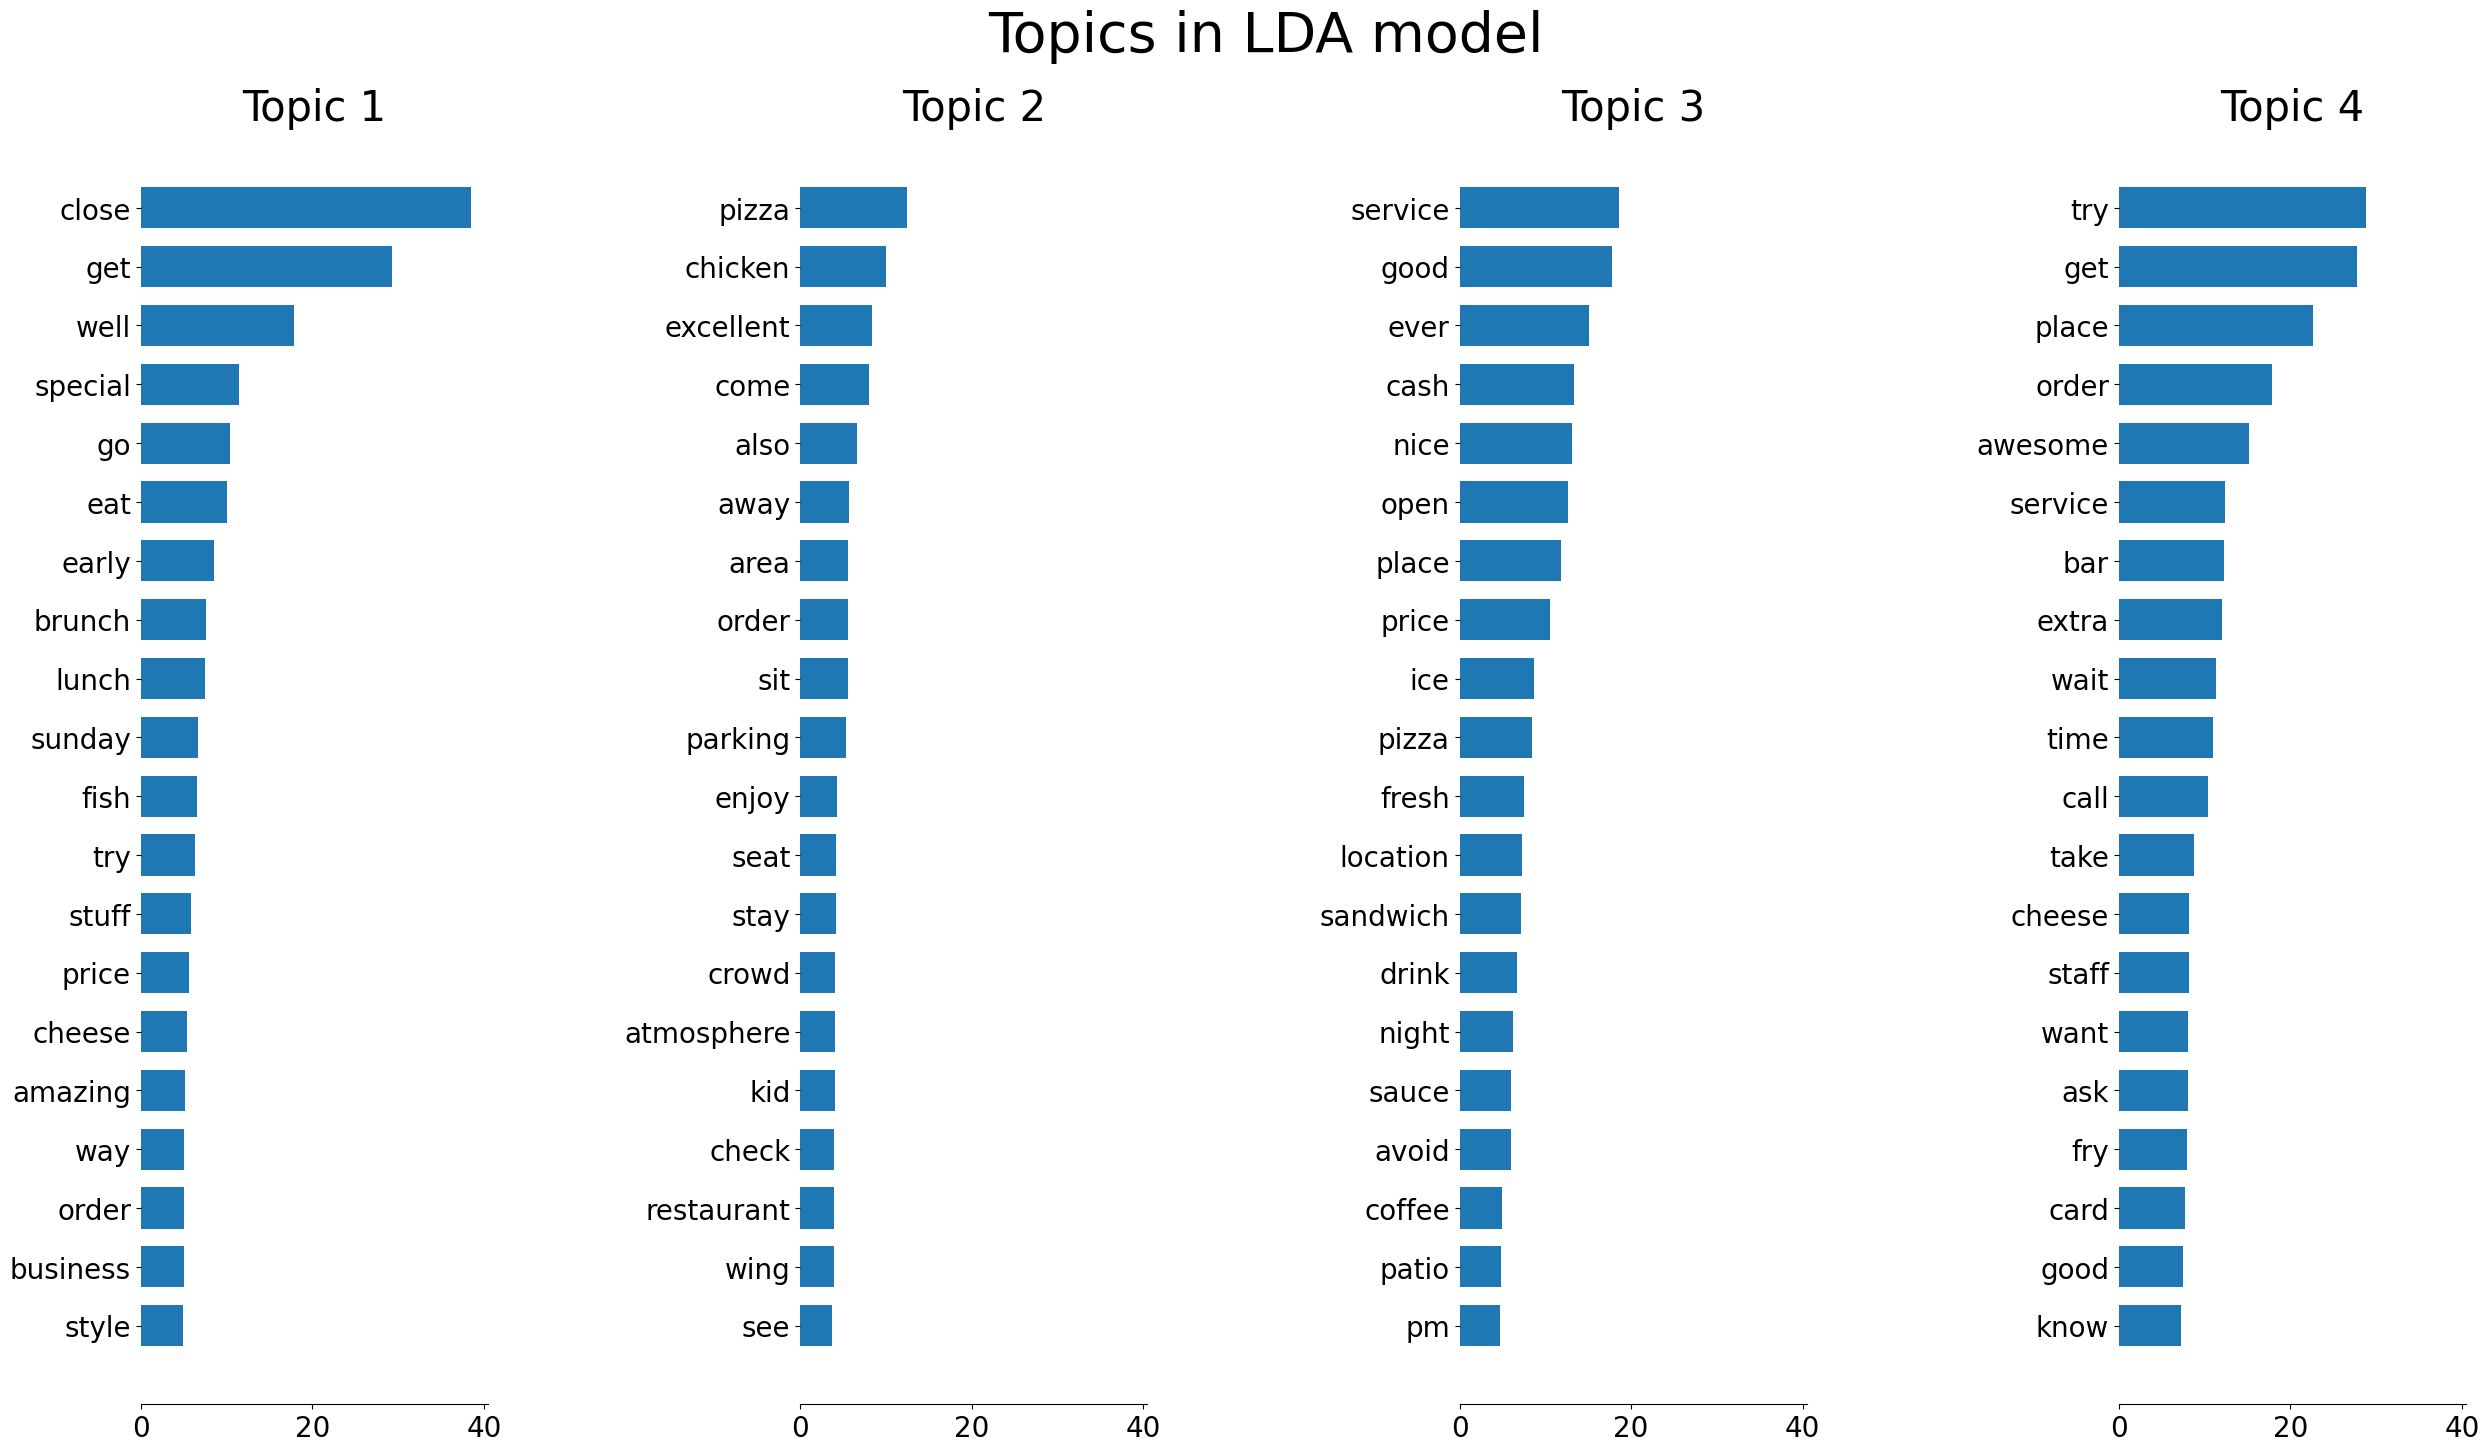

In [ ]:
# Visualise the result into bar charts in topic

%matplotlib inline
import matplotlib.pyplot as plt

# helper function to plot topics
# see Grisel et al.
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 4, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20  #how many words to be visualised in each topic

# get the list of words (feature names)
vec_feature_names = vectorizer.get_feature_names_out()

# print the top words per topic
plot_top_words(lda, vec_feature_names, n_top_words, 'Topics in LDA model')

In [ ]:
import pandas as pd
doc_topic = lda.transform(vec)
docsVStopics = pd.DataFrame(doc_topic, columns=["Topic"+str(i+1) for i in range(k)])
# df = df.join(docsVStopics)
# df['mostlikely_topic'] = docsVStopics.idxmax(axis=1)

tips_df.to_csv('topic_modeling_result.csv', index=False) # save the file to google drive
files.download('topic_modeling_result.csv') # download the file to your local machine
docsVStopics.info()
tips_df.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Topic1  552 non-null    float64
 1   Topic2  552 non-null    float64
 2   Topic3  552 non-null    float64
 3   Topic4  552 non-null    float64
dtypes: float64(4)
memory usage: 17.4 KB


,user_id,business_id,text,date,compliment_count,cleaned_review,Topic1,Topic2,Topic3,Topic4,mostlikely_topic
0,A5kkLvxwVS5jJZdS0Gm4ww,M1hsyjJDdQQeNP164FJ1pA,creole creamery is just down the street great...,2009-05-01 04:52:28+00:00,0,street great place dairy dessert,0.043457,0.041752,0.871737,0.043055,Topic3
1,F5he-BIIB1vRr_BpdZzJTw,UNtta3w643ZWsJ7JDxhC9g,get the steak sandwich with spagetti as your s...,2009-12-08 21:13:45+00:00,0,get steak sandwich side,0.848928,0.050041,0.050018,0.051014,Topic1
2,F5he-BIIB1vRr_BpdZzJTw,UNtta3w643ZWsJ7JDxhC9g,get one of their layers beers,2009-12-08 20:36:45+00:00,0,get layer beer,0.810139,0.062638,0.062589,0.064634,Topic1
3,4XA9DIbUIbcnkBZFLgs_2Q,sXaiyPC1fT6ESl-6t7eSXg,deep fried cheddar cheese balls,2009-06-22 15:26:59+00:00,0,deep fried cheddar cheese ball,0.204907,0.041786,0.710382,0.042925,Topic3
4,tzDfx3wfWTqtV0kxMJxKLg,vxLV9tci88Hsr1G01uleag,amazing white pizza,2009-07-24 22:18:50+00:00,0,amazing white pizza,0.308835,0.062656,0.065415,0.563094,Topic4
